author: @SteveEckel

This little script tests damped Rabi flopping as calculated with the optical
Bloch equations.

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import pylcp
import pylcp.rateeq
import pylcp.obe
from scipy.integrate import solve_ivp
plt.style.use('paper')

### Define the problem to start:

In [37]:
ham_det = -2.
laser_det = -2.

laserBeams = []
laserBeams.append(pylcp.laserBeam(np.array([1., 0., 0.]),
                                  pol=np.array([0., 0., 1.]),
                                  pol_coord='cartesian',
                                  delta=laser_det, beta=20.))
"""laserBeams.append(pylcp.laserBeam(np.array([1., 0., 0.]),
                                  pol=np.array([0., 0., 1.]),
                                  delta=0, beta=lambda R, k: 3))"""
magField = lambda R: np.zeros(R.shape)

# Now define the extremely simple Hamiltonian:
Hg = np.array([[0.]])
mugq = np.array([[[0.]], [[0.]], [[0.]]])
He = np.array([[-ham_det]])
mueq = np.array([[[0.]], [[0.]], [[0.]]])
dijq = np.array([[[0.]], [[1.]], [[0.]]])

gamma = 1.

hamiltonian = pylcp.hamiltonian()
hamiltonian.add_H_0_block('g', Hg)
hamiltonian.add_mu_q_block('g', mugq)
hamiltonian.add_H_0_block('e', He)
hamiltonian.add_mu_q_block('e', mugq)
hamiltonian.add_d_q_block('g', 'e', dijq, gamma=gamma)

hamiltonian.print_structure()

[[((<g|H_0|g> 1x1), (<g|mu_q|g> 1x1)) (<g|d_q|e> 1x1)]
 [(<e|d_q|g> 1x1) ((<e|H_0|e> 1x1), (<e|mu_q|e> 1x1))]]


### Create the equations:

In [38]:
# First the OBE:
obe = pylcp.obe(laserBeams, magField, hamiltonian,
                     transform_into_re_im=False)
rateeq = pylcp.rateeq(laserBeams, magField, hamiltonian)
print(obe.ev_mat['decay'])
#obe.ev_mat['decay'][:] = 0.
print(obe.ev_mat['d_q']['g->e'][1] + obe.ev_mat['d_q*']['g->e'][1] + obe.ev_mat['H0'])
print(obe.decay_rates)

[[ 0. +0.j  0. +0.j  0. +0.j  1. +0.j]
 [ 0. +0.j -0.5+0.j  0. +0.j  0. +0.j]
 [ 0. +0.j  0. +0.j -0.5+0.j  0. +0.j]
 [ 0. +0.j  0. +0.j  0. +0.j -1. +0.j]]
[[0.+0.j   0.-0.25j 0.+0.25j 0.+0.j  ]
 [0.-0.25j 0.-2.j   0.+0.j   0.+0.25j]
 [0.+0.25j 0.+0.j   0.+2.j   0.-0.25j]
 [0.+0.j   0.+0.25j 0.-0.25j 0.+0.j  ]]
{'g->e': array([ 0.+0.j, -1.+0.j])}


### Now, evolve it!

In [39]:
t_eval = np.linspace(0, 4*np.pi/gamma, 100)
rho0 = np.zeros((hamiltonian.n**2,), dtype='complex128')
rho0[0] = 1.
obe.set_initial_rho(rho0)
obe.evolve_density([t_eval[0], t_eval[-1]], t_eval=t_eval)

N0 = np.zeros((rateeq.hamiltonian.n,))
N0[0] = 1
rateeq.set_initial_pop(N0)
rateeq.evolve_populations([t_eval[0], t_eval[-1]], t_eval=t_eval)

### Plot it all up:

Text(0, 0.5, '$\\rho_{ii}$')

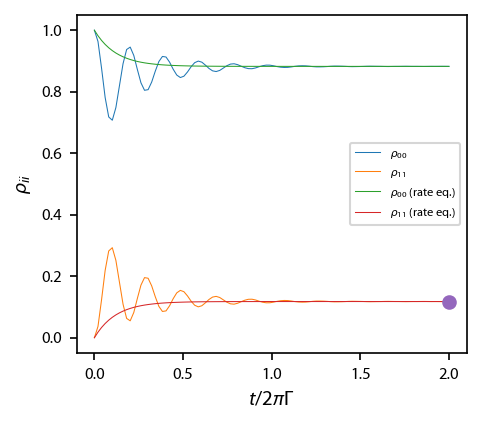

In [40]:
def final_value(s, det):
    return s/2/(1+s+4*det**2)

fig, ax = plt.subplots(1, 1, num='evolution')
ax.plot(obe.sol.t*gamma/2/np.pi, np.abs(obe.sol.rho[0, 0, :]), linewidth=0.5,
         label='$\\rho_{00}$')
ax.plot(obe.sol.t*gamma/2/np.pi, np.abs(obe.sol.rho[1, 1, :]), linewidth=0.5,
         label='$\\rho_{11}$')
ax.plot(rateeq.sol.t*gamma/2/np.pi, np.abs(rateeq.sol.y[0, :]), linewidth=0.5,
         label='$\\rho_{00}$ (rate eq.)')
ax.plot(rateeq.sol.t*gamma/2/np.pi, np.abs(rateeq.sol.y[-1, :]), linewidth=0.5,
         label='$\\rho_{11}$ (rate eq.)')
ax.plot(obe.sol.t[-1]*gamma/2/np.pi,
         final_value(len(laserBeams)*laserBeams[0].beta(np.array([0., 0., 0.])),
                     ham_det+laser_det) ,'o')
ax.legend(fontsize=6)
ax.set_xlabel('$t/2\pi\Gamma$')
ax.set_ylabel('$\\rho_{ii}$')